# Data Science Aplicada à Área da Saúde

Projeto de análise de dados da formação FIAMED da [DSA](https://www.datascienceacademy.com.br/)

## Modelagem Estatística - Venda de Medicamentos Falsificados

Medicamentos falsificados são medicamentos contaminados ou que contêm componente errado ou mesmo nenhum componente ativo. Alguns até possuem o componente ativo certo, mas na dose errada. Medicamentos falsificados são ilegais e prejudiciais à saúde. 

Estima-se que 10% dos medicamentos em todo mundo estão falsificados e o problema é ainda pior nos países em desenvolvimento, onde até 30% dos medicamentos são falsos. Milhões de pílulas, frascos e recipientes de medicamentos falsificados e ilegais estão sendo comercializados em todo o mundo. 

A Organização Mundial da Saúde (OMS) está trabalhando com a Organização Internacional de Polícia Criminal (Interpol) para desalojar as redes criminosas que arrecadam bilhões de dólares desse comércio criminoso. Apesar de todos esses esforços, as vendas de remédios falsificados parecem crescer a cada dia. Tornou-se um desafio implantar recursos para combatê-los que, eventualmente, tornam-se ineficazes. 

O governo decidiu então concentrar os esforços primeiro na investigação de operações ilegais de alto patrimônio líquido, em vez de tentar controlar todas elas. Para isso, eles coletaram dados que os ajudarão a prever números de vendas, dadas as características de uma operação ilegal.

Usaremos um dataset que contém diversos atributos e o total de vendas de medicamentos falsos (coluna Counterfeit_Sales). Os dados foram coletados de diversas operações ilegais de falsificação de medicamentos, durante as investigações.

O objetivo dessa análise é criar um modelo estatístico que ajude a compreender a relação entre os dados. Quais variáveis são mais relevantes para compreender o total e vendas de medicamentos falsificados?

### Carregar dados

In [1]:
# Importar pacotes
import scipy
import sklearn
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# Carrega arquivos
dados_treino = pd.read_csv('dados/counterfeit_train.csv')
dados_teste = pd.read_csv('dados/counterfeit_test.csv')

### Preparar dataset para manipulação

In [3]:
# Concatenação dos tadasets para exploração e pré-processamento
## Variável target como NA
dados_teste['Counterfeit_Sales'] = np.NaN

## Adiciona uma coluna indicando que o dado é de treino
dados_treino['data'] = 'treino'

## Adiciona uma coluna indicando que o dado é de teste
dados_teste['data'] = 'teste'

## Adiciona as colunas de treino em teste
dados_teste = dados_teste[dados_treino.columns]

## Concatena os datasets
dataset = pd.concat([dados_treino, dados_teste], axis=0)

### Visualização e limpeza de dados

In [4]:
# Shape
dataset.shape

(8523, 13)

In [5]:
# Visualiza o dataset
dataset.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026,treino
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520,treino
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920,treino
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130,treino
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402,treino


Exsitem variáveis categóricas, com as quais deverá ser usado a técnica de encoding.

In [6]:
# Tipo das variáveis
dataset.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
dtype: object

In [7]:
# Retiras as colunas de ID
dataset = dataset.drop(['Medicine_ID', 'DistArea_ID'], axis=1)

In [8]:
# Ispecionar valores únicos
dataset.nunique()

Counterfeit_Weight      415
Active_Since              9
Medicine_MRP           5970
Medicine_Type            16
SidEffect_Level           2
Availability_rating    7884
Area_Type                 4
Area_City_Type            3
Area_dist_level           4
Counterfeit_Sales      3142
data                      2
dtype: int64

#### Inspeção e manipulação da variável - Medicine_Type

In [9]:
# Quantidade de registros por medicamento
dataset['Medicine_Type'].value_counts()

Antibiotics           1232
Hreplacements         1200
Antiseptics            910
OralContraceptives     856
Antipyretics           682
Cardiac                649
Mstablizers            648
Tranquilizers          520
Analgesics             445
Antimalarial           425
Antacids               251
Statins                214
MuscleRelaxants        169
Antifungal             148
Stimulants             110
Antiviral               64
Name: Medicine_Type, dtype: int64

In [10]:
# Média de vendas por medicamento
dataset.groupby('Medicine_Type')['Counterfeit_Sales'].mean().round(2).sort_values(ascending = False)

Medicine_Type
Antiviral             2583.16
Antifungal            2444.06
Antibiotics           2397.20
Hreplacements         2376.12
Antiseptics           2366.59
Cardiac               2362.98
Statins               2309.45
Antipyretics          2292.72
Stimulants            2279.97
Antacids              2259.88
OralContraceptives    2245.22
Antimalarial          2192.68
Analgesics            2091.24
MuscleRelaxants       2091.09
Tranquilizers         2084.45
Mstablizers           2044.87
Name: Counterfeit_Sales, dtype: float64

In [11]:
# Aplicar label encoding por medicamento
medicine_type_dummy = pd.get_dummies(dataset['Medicine_Type'], prefix='MdType')
dataset = pd.concat([dataset, medicine_type_dummy], axis=1)
dataset = dataset.drop(['Medicine_Type', 'MdType_Antiviral'], axis=1)

In [12]:
dataset.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data,...,MdType_Antipyretics,MdType_Antiseptics,MdType_Cardiac,MdType_Hreplacements,MdType_Mstablizers,MdType_MuscleRelaxants,MdType_OralContraceptives,MdType_Statins,MdType_Stimulants,MdType_Tranquilizers
0,13.100,1995,160.2366,critical,0.070422,DownTown,Tier 1,Small,1775.5026,treino,...,0,0,0,0,0,0,0,0,0,0
1,NaN,1983,110.4384,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520,treino,...,0,0,0,0,1,0,0,0,0,0
2,9.025,1995,259.4092,mild,0.060783,DownTown,Tier 1,Small,2603.0920,treino,...,0,0,1,0,0,0,0,0,0,0
3,11.800,1995,99.9830,mild,0.065555,DownTown,Tier 1,Small,1101.7130,treino,...,0,0,0,0,0,0,1,0,0,0
4,NaN,1983,56.4402,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402,treino,...,0,0,0,1,0,0,0,0,0,0


#### Inspeção e manipulação da variável - SidEffect_Level

In [13]:
# Quantidade de registros por SidEffect_Level
dataset['SidEffect_Level'].value_counts()

mild        5517
critical    3006
Name: SidEffect_Level, dtype: int64

In [14]:
# Média de vendas por SidEffect_Level
dataset.groupby('SidEffect_Level')['Counterfeit_Sales'].mean().round(2).sort_values(ascending = False)

SidEffect_Level
critical    2319.61
mild        2259.60
Name: Counterfeit_Sales, dtype: float64

In [15]:
# Aplicar label encoding por SidEffect_Level
sideffect_level_dummy = pd.get_dummies(dataset['SidEffect_Level'], prefix='SidEffect_Level')
dataset = pd.concat([dataset, sideffect_level_dummy], axis=1)
dataset = dataset.drop(['SidEffect_Level', 'SidEffect_Level_mild'], axis=1)

In [16]:
dataset.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data,MdType_Analgesics,...,MdType_Antiseptics,MdType_Cardiac,MdType_Hreplacements,MdType_Mstablizers,MdType_MuscleRelaxants,MdType_OralContraceptives,MdType_Statins,MdType_Stimulants,MdType_Tranquilizers,SidEffect_Level_critical
0,13.100,1995,160.2366,0.070422,DownTown,Tier 1,Small,1775.5026,treino,0,...,0,0,0,0,0,0,0,0,0,1
1,NaN,1983,110.4384,0.013000,CityLimits,Tier 3,Medium,3069.1520,treino,0,...,0,0,0,1,0,0,0,0,0,0
2,9.025,1995,259.4092,0.060783,DownTown,Tier 1,Small,2603.0920,treino,0,...,0,1,0,0,0,0,0,0,0,0
3,11.800,1995,99.9830,0.065555,DownTown,Tier 1,Small,1101.7130,treino,0,...,0,0,0,0,0,1,0,0,0,0
4,NaN,1983,56.4402,0.248859,MidTownResidential,Tier 1,Small,158.9402,treino,0,...,0,0,1,0,0,0,0,0,0,1


#### Inspeção e manipulação da variável - Area_Type

In [17]:
# Contagem de registros por Area_Type
dataset['Area_Type'].value_counts()

DownTown              5577
MidTownResidential    1083
CityLimits             935
Industrial             928
Name: Area_Type, dtype: int64

In [18]:
# Aplicar label encoding para Area_Type
area_type_dummy = pd.get_dummies(dataset['Area_Type'], prefix='AType')
dataset = pd.concat([dataset, area_type_dummy], axis=1)
dataset = dataset.drop(['Area_Type', 'AType_Industrial'], axis=1)

In [19]:
dataset.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Area_City_Type,Area_dist_level,Counterfeit_Sales,data,MdType_Analgesics,MdType_Antacids,...,MdType_Mstablizers,MdType_MuscleRelaxants,MdType_OralContraceptives,MdType_Statins,MdType_Stimulants,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential
0,13.100,1995,160.2366,0.070422,Tier 1,Small,1775.5026,treino,0,0,...,0,0,0,0,0,0,1,0,1,0
1,NaN,1983,110.4384,0.013000,Tier 3,Medium,3069.1520,treino,0,0,...,1,0,0,0,0,0,0,1,0,0
2,9.025,1995,259.4092,0.060783,Tier 1,Small,2603.0920,treino,0,0,...,0,0,0,0,0,0,0,0,1,0
3,11.800,1995,99.9830,0.065555,Tier 1,Small,1101.7130,treino,0,0,...,0,0,1,0,0,0,0,0,1,0
4,NaN,1983,56.4402,0.248859,Tier 1,Small,158.9402,treino,0,0,...,0,0,0,0,0,0,1,0,0,1


#### Inspeção e manipulação da variável - Area_City_Type

In [20]:
# Contagem de registros de Area_City_Type
dataset['Area_City_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Area_City_Type, dtype: int64

In [21]:
# Média de vendas por Area_City_Type
dataset.groupby('Area_City_Type')['Counterfeit_Sales'].mean().round(2)

Area_City_Type
Tier 1    1962.31
Tier 2    2439.87
Tier 3    2376.00
Name: Counterfeit_Sales, dtype: float64

In [22]:
# Aplicar label encoding para Area_City_Type
area_city_type_dummie = pd.get_dummies(dataset['Area_City_Type'], prefix='ACType')
dataset = pd.concat([dataset, area_city_type_dummie], axis=1)
dataset['ACType_Tier2'] = dataset['ACType_Tier 2'].copy()
dataset['ACType_Tier3'] = dataset['ACType_Tier 3'].copy()
dataset = dataset.drop(['Area_City_Type', 'ACType_Tier 1', 'ACType_Tier 2', 'ACType_Tier 3'], axis=1)

In [23]:
dataset.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Area_dist_level,Counterfeit_Sales,data,MdType_Analgesics,MdType_Antacids,MdType_Antibiotics,...,MdType_OralContraceptives,MdType_Statins,MdType_Stimulants,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential,ACType_Tier2,ACType_Tier3
0,13.100,1995,160.2366,0.070422,Small,1775.5026,treino,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,NaN,1983,110.4384,0.013000,Medium,3069.1520,treino,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,9.025,1995,259.4092,0.060783,Small,2603.0920,treino,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,11.800,1995,99.9830,0.065555,Small,1101.7130,treino,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,NaN,1983,56.4402,0.248859,Small,158.9402,treino,0,0,0,...,0,0,0,0,1,0,0,1,0,0


#### Inspeção e manipulação da variável - Area_dist_level

In [24]:
# Contagem de valores por Area_dist_level
dataset['Area_dist_level'].value_counts()

Medium     2793
Unknown    2410
Small      2388
High        932
Name: Area_dist_level, dtype: int64

In [25]:
# Média de vendas por Area_dist_level
dataset.groupby('Area_dist_level')['Counterfeit_Sales'].mean().round(2)

Area_dist_level
High       2407.02
Medium     2775.05
Small      1998.41
Unknown    1950.35
Name: Counterfeit_Sales, dtype: float64

In [26]:
# Aplicar label encoding para Area_dist_level
area_dist_level_dummy = pd.get_dummies(dataset['Area_dist_level'], prefix='ADLevel')
dataset = pd.concat([dataset, area_dist_level_dummy], axis=1)
dataset = dataset.drop(['Area_dist_level', 'ADLevel_Unknown'], axis=1)

In [27]:
dataset.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales,data,MdType_Analgesics,MdType_Antacids,MdType_Antibiotics,MdType_Antifungal,...,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential,ACType_Tier2,ACType_Tier3,ADLevel_High,ADLevel_Medium,ADLevel_Small
0,13.100,1995,160.2366,0.070422,1775.5026,treino,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,NaN,1983,110.4384,0.013000,3069.1520,treino,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,9.025,1995,259.4092,0.060783,2603.0920,treino,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,11.800,1995,99.9830,0.065555,1101.7130,treino,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,NaN,1983,56.4402,0.248859,158.9402,treino,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [28]:
# Shape
dataset.shape

(8523, 30)

### Train Test Split

In [29]:
# Separar as variáveis para modelagem
## Dados de treino
dados_treino_final = dataset[dataset['data'] == 'treino']
dados_treino_final = dados_treino_final.drop(['data'], axis=1)

## Dados de teste
dados_teste_final = dataset[dataset['data'] == 'teste']
dados_teste_final = dados_teste_final.drop(['data'], axis=1)

In [30]:
# Excluir o dataset para liberar memória
del dataset

In [31]:
dados_treino_final.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales,MdType_Analgesics,MdType_Antacids,MdType_Antibiotics,MdType_Antifungal,MdType_Antimalarial,...,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential,ACType_Tier2,ACType_Tier3,ADLevel_High,ADLevel_Medium,ADLevel_Small
0,13.100,1995,160.2366,0.070422,1775.5026,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1
1,NaN,1983,110.4384,0.013000,3069.1520,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,9.025,1995,259.4092,0.060783,2603.0920,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,11.800,1995,99.9830,0.065555,1101.7130,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,NaN,1983,56.4402,0.248859,158.9402,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [32]:
dados_teste_final.head()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales,MdType_Analgesics,MdType_Antacids,MdType_Antibiotics,MdType_Antifungal,MdType_Antimalarial,...,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential,ACType_Tier2,ACType_Tier3,ADLevel_High,ADLevel_Medium,ADLevel_Small
0,NaN,1983,85.5328,0.112747,NaN,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,13.45,2000,257.1460,0.144446,NaN,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,7.10,2000,98.1172,0.144221,NaN,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,18.30,1996,135.3730,0.100388,NaN,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,NaN,1983,112.8016,0.022585,NaN,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [33]:
# domensões dos datasets
print('Dataset de Treino')
print(f'Número de features:\t{dados_treino_final.shape[1]}')
print(f'Número de observações:\t{dados_treino_final.shape[0]}')
print('\nDataset de Treino')
print(f'Número de features:\t{dados_teste_final.shape[1]}')
print(f'Número de observações:\t{dados_teste_final.shape[0]}')

Dataset de Treino
Número de features:	29
Número de observações:	6818

Dataset de Treino
Número de features:	29
Número de observações:	1705


In [34]:
# Verificar valores nulos nos dados de treino
dados_treino_final.isnull().mean().round(2)

Counterfeit_Weight           0.17
Active_Since                 0.00
Medicine_MRP                 0.00
Availability_rating          0.00
Counterfeit_Sales            0.00
MdType_Analgesics            0.00
MdType_Antacids              0.00
MdType_Antibiotics           0.00
MdType_Antifungal            0.00
MdType_Antimalarial          0.00
MdType_Antipyretics          0.00
MdType_Antiseptics           0.00
MdType_Cardiac               0.00
MdType_Hreplacements         0.00
MdType_Mstablizers           0.00
MdType_MuscleRelaxants       0.00
MdType_OralContraceptives    0.00
MdType_Statins               0.00
MdType_Stimulants            0.00
MdType_Tranquilizers         0.00
SidEffect_Level_critical     0.00
AType_CityLimits             0.00
AType_DownTown               0.00
AType_MidTownResidential     0.00
ACType_Tier2                 0.00
ACType_Tier3                 0.00
ADLevel_High                 0.00
ADLevel_Medium               0.00
ADLevel_Small                0.00
dtype: float64

count    5652.000000
mean       14.115057
std         4.649668
min         5.855000
25%         9.995000
50%        13.800000
75%        18.050000
max        22.650000
Name: Counterfeit_Weight, dtype: float64


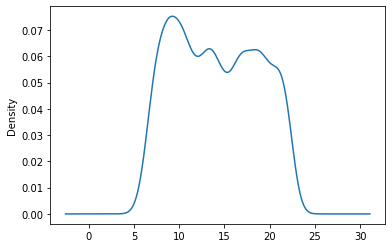

In [35]:
# Inspeção da variável Counterfeit_Weight
print(dados_treino_final['Counterfeit_Weight'].describe())
dados_treino_final['Counterfeit_Weight'].plot(kind='density');

In [36]:
# Método de imputação de valores nulos
dados_treino_final['Counterfeit_Weight'] = dados_treino_final['Counterfeit_Weight'].fillna((dados_treino_final['Counterfeit_Weight'].median()))

In [37]:
# Confirmar valores nulos
dados_treino_final.isnull().mean().round(2)

Counterfeit_Weight           0.0
Active_Since                 0.0
Medicine_MRP                 0.0
Availability_rating          0.0
Counterfeit_Sales            0.0
MdType_Analgesics            0.0
MdType_Antacids              0.0
MdType_Antibiotics           0.0
MdType_Antifungal            0.0
MdType_Antimalarial          0.0
MdType_Antipyretics          0.0
MdType_Antiseptics           0.0
MdType_Cardiac               0.0
MdType_Hreplacements         0.0
MdType_Mstablizers           0.0
MdType_MuscleRelaxants       0.0
MdType_OralContraceptives    0.0
MdType_Statins               0.0
MdType_Stimulants            0.0
MdType_Tranquilizers         0.0
SidEffect_Level_critical     0.0
AType_CityLimits             0.0
AType_DownTown               0.0
AType_MidTownResidential     0.0
ACType_Tier2                 0.0
ACType_Tier3                 0.0
ADLevel_High                 0.0
ADLevel_Medium               0.0
ADLevel_Small                0.0
dtype: float64

In [38]:
# Verificar valores nulos nos dados de teste
dados_teste_final.isnull().mean().round(2)

Counterfeit_Weight           0.17
Active_Since                 0.00
Medicine_MRP                 0.00
Availability_rating          0.00
Counterfeit_Sales            1.00
MdType_Analgesics            0.00
MdType_Antacids              0.00
MdType_Antibiotics           0.00
MdType_Antifungal            0.00
MdType_Antimalarial          0.00
MdType_Antipyretics          0.00
MdType_Antiseptics           0.00
MdType_Cardiac               0.00
MdType_Hreplacements         0.00
MdType_Mstablizers           0.00
MdType_MuscleRelaxants       0.00
MdType_OralContraceptives    0.00
MdType_Statins               0.00
MdType_Stimulants            0.00
MdType_Tranquilizers         0.00
SidEffect_Level_critical     0.00
AType_CityLimits             0.00
AType_DownTown               0.00
AType_MidTownResidential     0.00
ACType_Tier2                 0.00
ACType_Tier3                 0.00
ADLevel_High                 0.00
ADLevel_Medium               0.00
ADLevel_Small                0.00
dtype: float64

A variável `Counterfeit_Sales` é o target, por esse motivo está vazia.

Para a variável `Counterfeit_Weight`, será removido registros com valores missing.

In [39]:
# Reitirando valores nulos
dados_teste_final = dados_teste_final.dropna(subset = ['Counterfeit_Weight']) 

In [40]:
# Confirmar valores nulos
dados_treino_final.isnull().mean().round(2)

Counterfeit_Weight           0.0
Active_Since                 0.0
Medicine_MRP                 0.0
Availability_rating          0.0
Counterfeit_Sales            0.0
MdType_Analgesics            0.0
MdType_Antacids              0.0
MdType_Antibiotics           0.0
MdType_Antifungal            0.0
MdType_Antimalarial          0.0
MdType_Antipyretics          0.0
MdType_Antiseptics           0.0
MdType_Cardiac               0.0
MdType_Hreplacements         0.0
MdType_Mstablizers           0.0
MdType_MuscleRelaxants       0.0
MdType_OralContraceptives    0.0
MdType_Statins               0.0
MdType_Stimulants            0.0
MdType_Tranquilizers         0.0
SidEffect_Level_critical     0.0
AType_CityLimits             0.0
AType_DownTown               0.0
AType_MidTownResidential     0.0
ACType_Tier2                 0.0
ACType_Tier3                 0.0
ADLevel_High                 0.0
ADLevel_Medium               0.0
ADLevel_Small                0.0
dtype: float64

## Modelagem

### Primeira tentativa de modelo

In [41]:
# domensões dos datasets
print('Dataset de Treino')
print(f'Número de features:\t{dados_treino_final.shape[1]}')
print(f'Número de observações:\t{dados_treino_final.shape[0]}')
print('\nDataset de Treino')
print(f'Número de features:\t{dados_teste_final.shape[1]}')
print(f'Número de observações:\t{dados_teste_final.shape[0]}')

Dataset de Treino
Número de features:	29
Número de observações:	6818

Dataset de Treino
Número de features:	29
Número de observações:	1408


In [42]:
# Lista com os nomes dos atributos (variáveis explicativas)
atributos = dados_treino_final.columns.values.tolist()
atributos.remove('Counterfeit_Sales')
print(atributos)

['Counterfeit_Weight', 'Active_Since', 'Medicine_MRP', 'Availability_rating', 'MdType_Analgesics', 'MdType_Antacids', 'MdType_Antibiotics', 'MdType_Antifungal', 'MdType_Antimalarial', 'MdType_Antipyretics', 'MdType_Antiseptics', 'MdType_Cardiac', 'MdType_Hreplacements', 'MdType_Mstablizers', 'MdType_MuscleRelaxants', 'MdType_OralContraceptives', 'MdType_Statins', 'MdType_Stimulants', 'MdType_Tranquilizers', 'SidEffect_Level_critical', 'AType_CityLimits', 'AType_DownTown', 'AType_MidTownResidential', 'ACType_Tier2', 'ACType_Tier3', 'ADLevel_High', 'ADLevel_Medium', 'ADLevel_Small']


In [43]:
# Modelo de regressão
modelo_v1 = sm.OLS(
    endog=dados_treino_final['Counterfeit_Sales'],
    exog=sm.add_constant(dados_treino_final[atributos])
).fit()

In [44]:
# Sumário
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Counterfeit_Sales   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     319.1
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:09:26   Log-Likelihood:                -57499.
No. Observations:                6818   AIC:                         1.151e+05
Df Residuals:                    6789   BIC:                         1.153e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -7.269e+04    2.3e+04     -3.161      0.002   -1.18e+05   -2.76e+04
Counterfeit_Weight           -2.8762      3.214     -0.895      0.371      -9.177       3.425
Active_Since                 36.3585     11.539      3.151      0.002      13.738      58.979
Medicine_MRP                 15.5675      0.218     71.267      0.000      15.139      15.996
Availability_rating        -259.2855    275.090     -0.943      0.346    -798.548     279.977
MdType_Analgesics          -293.1411    170.183     -1.723      0.085    -626.753      40.471
MdType_Antacids            -274.7942    177.338     -1.550      0.121    -622.433      72.844
MdType_Antibiotics         -239.6721    163.332     -1.467      0.142    -559.855      80.511
MdType_Antifungal          -310.5154    191.349     -1.623      0.105    -685.618      64.588
MdType_Antimalarial        -328.3836    170.589     -1.925      0.054    -662.792       6.025
MdType_Antipyretics        -346.8374    166.476     -2.083      0.037    -673.183     -20.492
MdType_Antiseptics         -314.5998    165.168     -1.905      0.057    -638.381       9.181
MdType_Cardiac             -252.5937    166.672     -1.516      0.130    -579.323      74.135
MdType_Hreplacements       -297.7519    163.292     -1.823      0.068    -617.855      22.351
MdType_Mstablizers         -301.0081    166.819     -1.804      0.071    -628.026      26.009
MdType_MuscleRelaxants     -251.0852    185.786     -1.351      0.177    -615.285     113.114
MdType_OralContraceptives  -308.7347    164.896     -1.872      0.061    -631.982      14.513
MdType_Statins             -287.4141    181.741     -1.581      0.114    -643.682      68.854
MdType_Stimulants          -240.1285    196.302     -1.223      0.221    -624.943     144.686
MdType_Tranquilizers       -343.4996    168.946     -2.033      0.042    -674.686     -12.313
SidEffect_Level_critical     17.5337     31.181      0.562      0.574     -43.590      78.657
AType_CityLimits           2569.4450    283.028      9.078      0.000    2014.621    3124.269
AType_DownTown              368.8560    111.369      3.312      0.001     150.538     587.174
AType_MidTownResidential  -1055.4560    150.414     -7.017      0.000   -1350.315    -760.597
ACType_Tier2                -94.5647     99.258     -0.953      0.341    -289.141     100.011
ACType_Tier3               -355.3425    169.919     -2.091      0.037    -688.436     -22.249
ADLevel_High                875.4646    281.889      3.106      0.002     322.874    1428.055
ADLevel_Medium              158.7425     78.259      2.028      0.043       5.330     312.155
ADLevel_Small               131.9510     50.336      2.621      0.009      33.277     230.625
===========================================================================

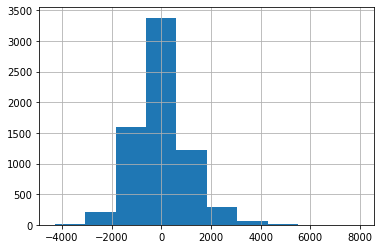

In [45]:
modelo_v1.resid.hist();

### Segunda tentativa - analizar multicolinearidade

In [46]:
# Avaliar multicolinearidade
correlacao = dados_treino_final.corr()

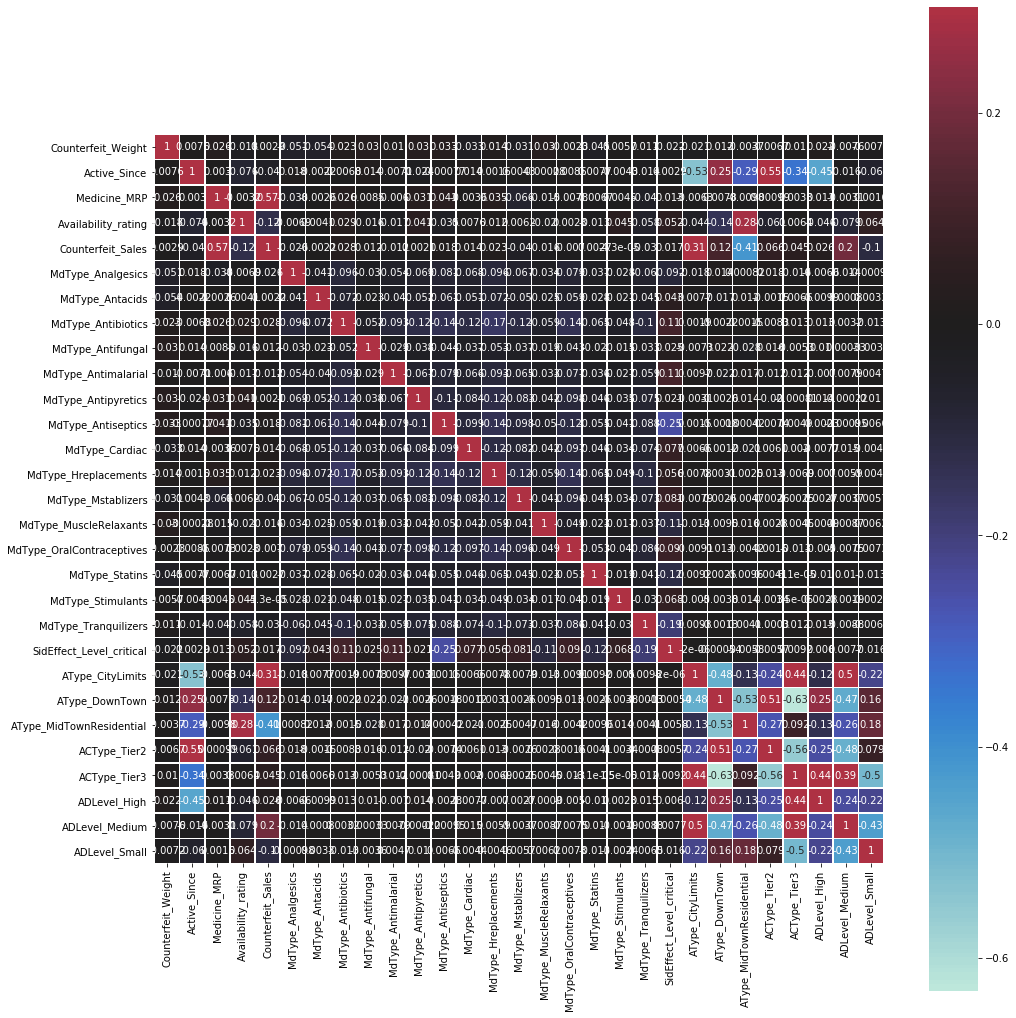

In [47]:
# Visualizar multicolinearidade
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlacao, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, ax=ax)
plt.tight_layout()

#### Avaliar a Variance Inflation Factor - VIF

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [49]:
atributos_2 = '+'.join(atributos)
atributos_2

'Counterfeit_Weight+Active_Since+Medicine_MRP+Availability_rating+MdType_Analgesics+MdType_Antacids+MdType_Antibiotics+MdType_Antifungal+MdType_Antimalarial+MdType_Antipyretics+MdType_Antiseptics+MdType_Cardiac+MdType_Hreplacements+MdType_Mstablizers+MdType_MuscleRelaxants+MdType_OralContraceptives+MdType_Statins+MdType_Stimulants+MdType_Tranquilizers+SidEffect_Level_critical+AType_CityLimits+AType_DownTown+AType_MidTownResidential+ACType_Tier2+ACType_Tier3+ADLevel_High+ADLevel_Medium+ADLevel_Small'

In [50]:
y, X = dmatrices('Counterfeit_Sales ~' + atributos_2, dados_treino_final, return_type='dataframe')

In [51]:
X

,Intercept,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,MdType_Analgesics,MdType_Antacids,MdType_Antibiotics,MdType_Antifungal,MdType_Antimalarial,...,MdType_Tranquilizers,SidEffect_Level_critical,AType_CityLimits,AType_DownTown,AType_MidTownResidential,ACType_Tier2,ACType_Tier3,ADLevel_High,ADLevel_Medium,ADLevel_Small
0,1.0,13.100,1995.0,160.2366,0.070422,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,13.800,1983.0,110.4384,0.013000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,9.025,1995.0,259.4092,0.060783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,11.800,1995.0,99.9830,0.065555,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,13.800,1983.0,56.4402,0.248859,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,1.0,8.535,1995.0,204.1452,0.112963,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6814,1.0,20.650,1995.0,235.1088,0.131103,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6815,1.0,20.000,2005.0,193.6292,0.105096,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6816,1.0,10.180,2000.0,162.8682,0.099957,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
# Para cada valor de X calcula o VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i).round(2) for i in range(X.shape[1])]
vif['Atributos'] = X.columns

In [53]:
vif.sort_values(by=['VIF Factor'], ascending=False)

,VIF Factor,Atributos
0,2900628.70,Intercept
2,51.14,Active_Since
26,42.62,ADLevel_High
21,42.26,AType_CityLimits
25,37.65,ACType_Tier3
13,17.94,MdType_Hreplacements
7,17.85,MdType_Antibiotics
22,15.32,AType_DownTown
11,14.20,MdType_Antiseptics
23,13.85,AType_MidTownResidential


In [54]:
atributos_3 = list(vif.sort_values(by=['VIF Factor'], ascending=False)[-18::]['Atributos'])
atributos_3

['ACType_Tier2',
 'MdType_Antipyretics',
 'MdType_Cardiac',
 'MdType_Mstablizers',
 'MdType_Tranquilizers',
 'MdType_Analgesics',
 'MdType_Antimalarial',
 'ADLevel_Medium',
 'MdType_Antacids',
 'MdType_Statins',
 'MdType_MuscleRelaxants',
 'MdType_Antifungal',
 'MdType_Stimulants',
 'ADLevel_Small',
 'SidEffect_Level_critical',
 'Availability_rating',
 'Counterfeit_Weight',
 'Medicine_MRP']

In [55]:
atributos_4 = '+'.join(atributos_3)
atributos_4

'ACType_Tier2+MdType_Antipyretics+MdType_Cardiac+MdType_Mstablizers+MdType_Tranquilizers+MdType_Analgesics+MdType_Antimalarial+ADLevel_Medium+MdType_Antacids+MdType_Statins+MdType_MuscleRelaxants+MdType_Antifungal+MdType_Stimulants+ADLevel_Small+SidEffect_Level_critical+Availability_rating+Counterfeit_Weight+Medicine_MRP'

In [56]:
y, X = dmatrices('Counterfeit_Sales ~' + atributos_4, dados_treino_final, return_type='dataframe')

In [57]:
X

,Intercept,ACType_Tier2,MdType_Antipyretics,MdType_Cardiac,MdType_Mstablizers,MdType_Tranquilizers,MdType_Analgesics,MdType_Antimalarial,ADLevel_Medium,MdType_Antacids,MdType_Statins,MdType_MuscleRelaxants,MdType_Antifungal,MdType_Stimulants,ADLevel_Small,SidEffect_Level_critical,Availability_rating,Counterfeit_Weight,Medicine_MRP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.070422,13.100,160.2366
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013000,13.800,110.4384
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.060783,9.025,259.4092
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.065555,11.800,99.9830
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.248859,13.800,56.4402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.112963,8.535,204.1452
6814,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.131103,20.650,235.1088
6815,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.105096,20.000,193.6292
6816,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.099957,10.180,162.8682


In [58]:
# Para cada valor de X calcula o VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i).round(2) for i in range(X.shape[1])]
vif['Atributos'] = X.columns

In [59]:
vif.sort_values(by=['VIF Factor'], ascending=False)

,VIF Factor,Atributos
0,27.14,Intercept
8,1.67,ADLevel_Medium
1,1.36,ACType_Tier2
14,1.27,ADLevel_Small
15,1.11,SidEffect_Level_critical
5,1.10,MdType_Tranquilizers
4,1.08,MdType_Mstablizers
2,1.07,MdType_Antipyretics
3,1.07,MdType_Cardiac
6,1.06,MdType_Analgesics


In [60]:
# Modelo de regressão
modelo_v2 = sm.OLS(
    endog=dados_treino_final['Counterfeit_Sales'],
    exog=sm.add_constant(dados_treino_final[atributos_3])
).fit()



In [61]:
# Sumário
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Counterfeit_Sales   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     266.6
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:09:30   Log-Likelihood:                -58541.
No. Observations:                6818   AIC:                         1.171e+05
Df Residuals:                    6799   BIC:                         1.173e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -411.8085     81.903     -5.028      0.000    -572.365    -251.252
ACType_Tier2               736.6073     39.045     18.866      0.000     660.067     813.147
MdType_Antipyretics        -60.8812     60.381     -1.008      0.313    -179.246      57.484
MdType_Cardiac              43.3704     61.224      0.708      0.479     -76.648     163.388
MdType_Mstablizers         -20.2331     61.803     -0.327      0.743    -141.387     100.921
MdType_Tranquilizers       -60.2495     68.446     -0.880      0.379    -194.426      73.927
MdType_Analgesics          -43.9321     72.842     -0.603      0.546    -186.725      98.861
MdType_Antimalarial        -97.3344     74.401     -1.308      0.191    -243.183      48.514
ADLevel_Medium            1092.2398     43.382     25.177      0.000    1007.198    1177.282
MdType_Antacids            -27.9201     93.389     -0.299      0.765    -210.991     155.151
MdType_Statins              11.6938    103.811      0.113      0.910    -191.808     215.196
MdType_MuscleRelaxants     -85.5819    113.091     -0.757      0.449    -307.276     136.112
MdType_Antifungal           21.2700    125.318      0.170      0.865    -224.392     266.932
MdType_Stimulants           11.6829    135.460      0.086      0.931    -253.860     277.226
ADLevel_Small               56.9423     39.321      1.448      0.148     -20.140     134.025
SidEffect_Level_critical    40.1991     34.730      1.157      0.247     -27.882     108.281
Availability_rating      -2893.8929    309.967     -9.336      0.000   -3501.525   -2286.261
Counterfeit_Weight          -3.7216      3.740     -0.995      0.320     -11.054       3.611
Medicine_MRP                15.6138      0.254     61.436      0.000      15.116      16.112
==============================================================================
Omnibus:                      721.515   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1471.745
Skew:                           0.678   Prob(JB):                         0.00
Kurtosis:                       4.829   Cond. No.                     3.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

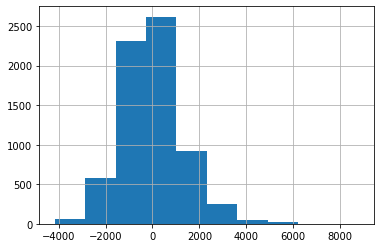

In [62]:
# Plotando os resíduos
modelo_v2.resid.hist();

### Modelo 3 - Padronização dos dados

In [63]:
# Padronizando os dados
from sklearn.preprocessing import StandardScaler

# Escala
scaler = StandardScaler()
scaler.fit(dados_treino_final[atributos_3])
scaled_features = scaler.transform(dados_treino_final[atributos_3])

# Criando um dataframe com dados em escala
scaled_features_df = pd.DataFrame(scaled_features, columns = atributos_3, index = dados_treino_final.index)
scaled_features_df.head()

,ACType_Tier2,MdType_Antipyretics,MdType_Cardiac,MdType_Mstablizers,MdType_Tranquilizers,MdType_Analgesics,MdType_Antimalarial,ADLevel_Medium,MdType_Antacids,MdType_Statins,MdType_MuscleRelaxants,MdType_Antifungal,MdType_Stimulants,ADLevel_Small,SidEffect_Level_critical,Availability_rating,Counterfeit_Weight,Medicine_MRP
0,-0.700428,-0.292101,-0.287941,-0.285544,-0.256214,-0.234715,4.371738,-0.690910,-0.176509,-0.158458,-0.144262,-0.128646,-0.118872,1.592579,1.363781,-0.170030,-0.226974,0.142044
1,-0.700428,-0.292101,-0.287941,3.502084,-0.256214,-0.234715,-0.228742,1.447367,-0.176509,-0.158458,-0.144262,-0.128646,-0.118872,-0.627912,-0.733255,-1.285498,-0.061675,-0.658577
2,-0.700428,-0.292101,3.472939,-0.285544,-0.256214,-0.234715,-0.228742,-0.690910,-0.176509,-0.158458,-0.144262,-0.128646,-0.118872,1.592579,-0.733255,-0.357270,-1.189253,1.736475
3,-0.700428,-0.292101,-0.287941,-0.285544,-0.256214,-0.234715,-0.228742,-0.690910,-0.176509,-0.158458,-0.144262,-0.128646,-0.118872,1.592579,-0.733255,-0.264562,-0.533959,-0.826672
4,-0.700428,-0.292101,-0.287941,-0.285544,-0.256214,-0.234715,-0.228742,-0.690910,-0.176509,-0.158458,-0.144262,-0.128646,-0.118872,1.592579,1.363781,3.296290,-0.061675,-1.526724


In [64]:
# Modelo de regressão
modelo_v3 = sm.OLS(
    endog=dados_treino_final['Counterfeit_Sales'],
    exog=sm.add_constant(scaled_features_df)
).fit()

In [65]:
# Sumário
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Counterfeit_Sales   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     266.6
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:09:31   Log-Likelihood:                -58541.
No. Observations:                6818   AIC:                         1.171e+05
Df Residuals:                    6799   BIC:                         1.173e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2280.5835     15.723    145.050      0.000    2249.762    2311.405
ACType_Tier2               346.1294     18.347     18.866      0.000     310.164     382.095
MdType_Antipyretics        -16.3854     16.251     -1.008      0.313     -48.242      15.471
MdType_Cardiac              11.5320     16.279      0.708      0.479     -20.380      43.444
MdType_Mstablizers          -5.3419     16.317     -0.327      0.743     -37.329      26.645
MdType_Tranquilizers       -14.4858     16.457     -0.880      0.379     -46.746      17.774
MdType_Analgesics           -9.7731     16.204     -0.603      0.546     -41.539      21.993
MdType_Antimalarial        -21.1575     16.172     -1.308      0.191     -52.860      10.546
ADLevel_Medium             510.8038     20.288     25.177      0.000     471.032     550.575
MdType_Antacids             -4.7793     15.986     -0.299      0.765     -36.117      26.558
MdType_Statins               1.8076     16.047      0.113      0.910     -29.649      33.264
MdType_MuscleRelaxants     -12.0945     15.982     -0.757      0.449     -43.424      19.235
MdType_Antifungal            2.6918     15.859      0.170      0.865     -28.397      33.781
MdType_Stimulants            1.3694     15.878      0.086      0.931     -29.756      32.495
ADLevel_Small               25.6440     17.708      1.448      0.148      -9.070      60.358
SidEffect_Level_critical    19.1695     16.561      1.157      0.247     -13.296      51.635
Availability_rating       -148.9706     15.956     -9.336      0.000    -180.250    -117.691
Counterfeit_Weight         -15.7599     15.840     -0.995      0.320     -46.811      15.291
Medicine_MRP               971.1703     15.808     61.436      0.000     940.182    1002.159
==============================================================================
Omnibus:                      721.515   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1471.745
Skew:                           0.678   Prob(JB):                         0.00
Kurtosis:                       4.829   Cond. No.                         2.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---